<a href="https://colab.research.google.com/github/tabbydoc/dl4td/blob/master/rcnn_tf2_ipynb.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# TabbyPDF

> TabbyPDF - Это проект для распознования таблиц в изображениях документов.
Данный ноутбук автоматизировал весь процесс, состоящий из: 
1.   Подготовка данных к обучению
2.   Обучение нейронной сети
3.   Тестирование обученной модели








Первым делом необходимо сформировать структуру всего проекта.
Импортируем нужные для этого библиотеки:

In [ ]:
import os
import sys
from google.colab import drive, files

# Формирование структуры проекта

## Создание директорий

Создаём новые директории для хранения датасетов, файлов типа TFRecord, предобученную модель и некоторые другие локальные файлы.

In [ ]:
for dir in ["Tabby", "Tabby/Data", "Tabby/Data/Out", "Tabby/Data/Local", "Tabby/Records", "Tabby/Pretrained_model"]:
    if not os.path.exists(os.path.join("/content", dir)):
        os.mkdir(os.path.join("/content", dir))

Определяем константы всех путей

In [ ]:
TABBY_DIR  = "/content/Tabby"
DATA_DIR   = os.path.join(TABBY_DIR, "Data")
PRETRAINED_DIR   = os.path.join(TABBY_DIR, "Pretrained_model")
OUT_DATA   = os.path.join(DATA_DIR, "Out")
LOCAL_DATA = os.path.join(DATA_DIR, "Local")
DLTD_DATA  = os.path.join(TABBY_DIR, "dl4td")
RECORD_DIR = os.path.join(TABBY_DIR, "Records")

## Установка Object Detection API

> Object Detection API - Это обнаружение объектов и обозначение их ограничивающей рамкой. Задача Object Detection в нахождении координат этой рамки. 

Сделаем текущей директорией: `/content/Tabby`

In [ ]:
%cd $TABBY_DIR

/content/Tabby


Клонируем репозиторий `tensorflow/models`, в котором находятся все нужны библиотеки и сам Object Detection

In [ ]:
!git clone --depth 1 https://github.com/tensorflow/models.git

Cloning into 'models'...
remote: Enumerating objects: 2303, done.
remote: Counting objects: 100% (2303/2303), done.
remote: Compressing objects: 100% (1993/1993), done.
remote: Total 2303 (delta 566), reused 946 (delta 287), pack-reused 0
Receiving objects: 100% (2303/2303), 30.58 MiB | 16.99 MiB/s, done.
Resolving deltas: 100% (566/566), done.


Определим константы путей для клонируемого репозитория

In [ ]:
TF_MODELS_DIR = os.path.join(TABBY_DIR, "models")
TF_MODELS_RESEARCH_DIR = os.path.join(TF_MODELS_DIR, "research/")
SLIM_DIR = os.path.join(TF_MODELS_RESEARCH_DIR, "slim")

### Установка Cocoapi

Для корректной работы Object Detection необходимо установить protobuf

Клонируем репозиторий `cocodataset/cocoapi`

In [ ]:
!git clone https://github.com/cocodataset/cocoapi.git

Cloning into 'cocoapi'...
remote: Enumerating objects: 975, done.
remote: Total 975 (delta 0), reused 0 (delta 0), pack-reused 975
Receiving objects: 100% (975/975), 11.72 MiB | 12.02 MiB/s, done.
Resolving deltas: 100% (576/576), done.


Переходим в директорию `cocoapi/PythonAPI`

In [ ]:
%cd cocoapi/PythonAPI

/content/Tabby/cocoapi/PythonAPI


Делаем make

In [ ]:
!make

python setup.py build_ext --inplace
running build_ext
cythoning pycocotools/_mask.pyx to pycocotools/_mask.c
/usr/local/lib/python3.6/dist-packages/Cython/Compiler/Main.py:369: FutureWarning: Cython directive 'language_level' not set, using 2 for now (Py2). This will change in a later release! File: /content/Tabby/cocoapi/PythonAPI/pycocotools/_mask.pyx
  tree = Parsing.p_module(s, pxd, full_module_name)
building 'pycocotools._mask' extension
creating build
creating build/common
creating build/temp.linux-x86_64-3.6
creating build/temp.linux-x86_64-3.6/pycocotools
x86_64-linux-gnu-gcc -pthread -DNDEBUG -g -fwrapv -O2 -Wall -g -fstack-protector-strong -Wformat -Werror=format-security -Wdate-time -D_FORTIFY_SOURCE=2 -fPIC -I/usr/local/lib/python3.6/dist-packages/numpy/core/include -I../common -I/usr/include/python3.6m -c ../common/maskApi.c -o build/temp.linux-x86_64-3.6/../common/maskApi.o -Wno-cpp -Wno-unused-function -std=c99
../common/maskApi.c: In function ‘rleDecode’:
../common/mask

Копируем папку pycocotools в директорию `researcch` (/content/Tabby/models/research)

In [ ]:
!cp -r pycocotools "$TF_MODELS_RESEARCH_DIR"

Перемещаемся в директорию `researcch` (/content/Tabby/models/research)

In [ ]:
%cd $TF_MODELS_RESEARCH_DIR

/content/Tabby/models/research


Настраиваем protoc для Object Detection 

In [ ]:
!protoc object_detection/protos/*.proto --python_out=.
!export PYTHONPATH=$PYTHONPATH:`pwd`:`pwd`/slim

Добавляем  глобальные пути до директорий `research` и `slim`(/content/Tabby/models/research/slim)

In [ ]:
sys.path.append(SLIM_DIR)
sys.path.append(TF_MODELS_RESEARCH_DIR)

Вернёмся к директории `/content`

In [ ]:
%cd "/content"

/content


## Скачивание датасетов

Скачиваем датасет Marmot

In [ ]:
!wget https://www.icst.pku.edu.cn/cpdp/docs/20190424190300041510.zip

--2020-11-15 04:50:28--  https://www.icst.pku.edu.cn/cpdp/docs/20190424190300041510.zip
Resolving www.icst.pku.edu.cn (www.icst.pku.edu.cn)... 115.27.240.135, 2001:da8:201:1920::731b:f087
Connecting to www.icst.pku.edu.cn (www.icst.pku.edu.cn)|115.27.240.135|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 454913711 (434M) [application/zip]
Saving to: ‘20190424190300041510.zip’

2019042419030004151 100%[===================>] 433.84M  3.67MB/s    in 2m 31s  

2020-11-15 04:53:01 (2.88 MB/s) - ‘20190424190300041510.zip’ saved [454913711/454913711]



Распаковываем в папку `/content/Tabby`

In [ ]:
!unzip -qq 20190424190300041510.zip -d "$DATA_DIR"

## Добавление своего датасета

Для добавления своего датасета необходимо написать скрипт для конвертации в формат PASCAL VOC.





### Особенность формата PASCAL VOC

PASCAL VOC - это формат, который представляет собой директорию с изображениями и с XML файлами. Также в этом формате присутствует файл trainval.txt, в котором хранятся названия всех файлов.

XML файлы хранят некоторую информацию о классе, который нужно распознать. Они хранят название файла (изображения), ширину и высоту изображения, параметр depth, параметр segmented и коллекцию объектов. В этой коллекции хранится название класса и координаты xmin, xmax, ymin, ymax. Эти координаты описывают, так называемую, область интереса (левый верхний край и нижний правый край).

Пример XML файла:

```xml
<annotation>
    <filename>cTDaR_s001.jpg</filename>
    <size>
        <width>4696</width>
        <height>3746</height>
        <depth>3</depth>
    </size>
    <segmented>0</segmented>
    <object>
        <name>table</name>
        <bndbox>
            <xmin>38</xmin>
            <ymin>36</ymin>
            <xmax>4575</xmax>
            <ymax>3687</ymax>
        </bndbox>
    </object>
</annotation>
```

### Скрипт по конвертации

Скрипт по конвертации должен записать данные размеченной области в XML файл в соответствии  с форматом PASCAL VOC (XML файлы хранятся в папке "annotations/xmls"). Также необходимо записать в файл trainval.txt названия файлов через знак переноса.

```xml
POD_0001tuned_0
POD_0001tuned_1
POD_0001tuned_2
```

Запуск скрипта осуществляется с помощью двух параметров запуска: входная директория с датасетом, директория сохранения нового датасета. Параметры определяются `-i <input folder>` и `-o <output folder>` соответственно.

Код для корректного (для данного проекта) чтения параметров:

```python
import getopt
import sys

argv = sys.argv[1:]

try:
    opts, args = getopt.getopt(argv, "hi:o:", ["input_folder=", "output_folder="])
except getopt.GetoptError:
    print('test.py -i <input folder> -o <output folder>')
    sys.exit(2)
for opt, arg in opts:
    if opt in ("-i", "--i"):
        input_path = arg
    elif opt in ("-o", "--o"):
        output_path = arg
```

## Клонирование проекта DL4TD

> **Dl4td** - это автоматизированная система для создания и настройки рабочего процесса по подготовки данных для обучения ANN сети на распознавание таблиц в документах через Object Detection. 

[Подробнее о DL4TD](https://github.com/tabbydoc/dl4td)

Процесс подготовки данных состоит из конвертации датасетов в унифицированный формат, преобразования изображений, аугментация методом аффинных преобразования данных, некоторая валидация данных и создания входных файлов типа TF Records (train.record - обучающая выборка и val.record - тестовая выборка).

*Подробнее в статье (On automated workflow for fine-tuning deep neural network models for table detection in document images)*


Перемещаемся в директорию `/content/Tabby`



In [ ]:
%cd $TABBY_DIR

/content/Tabby


Клонируем репозиторий

In [ ]:
!git clone -q --depth 1 https://github.com/tabbydoc/dl4td.git

## Настройка config файла

Config.ini - файл конфигурации, в котором описываются все настройки для конкретного этапа.

Находится этот файл в директории `/content/Tabby/dl4td/config.ini`

### Инициализация

> Если данные не нуждаются в каком-либо шаге (аугментация, конвертация и т.д.) и этот шаг нужно пропустить, то нужно в параметре `script_to_*` указать пустой путь к скрипту. Однако если указать пустой путь к датасету, то скрипт остановится с ошибкой.

Импортируем библиотеку для работы с ini файлами и инициализируем переменную 

In [ ]:
import configparser
config = configparser.ConfigParser()

Пусть пока это будет тут как напоминание, что это надо удалить

In [ ]:
config.add_section("settings")
config.set("settings", "train", "no")

### Настройка общих параметров

В `config.ini` файле параметры поделены на секции. Первая секция datasets отвечает за общие параметры для всех датасетов такие? как путь к папке, где будет унифицированный, преобразованный и расширенный датасет и путь к локальной директории, где хранятся временные файлы. Пример:
```ini
    [datasets]
    output_path = Data/output_dir
    local_path = Data/local
```

Создадим эту секцию и заполним её нужными параметрами

In [ ]:
config.add_section("datasets")
config.set("datasets", "output_path", OUT_DATA)
config.set("datasets", "local_path", LOCAL_DATA)

### Добавляем секцию с датасетом

Далее "добавляем" датасет в наш рабочий процесс. Для этого добавляем секцию `data_NAME`, где `NAME` - название датасета (Только буквами и цифрами. Без пробелов).

В этой секции 4 параметра. Первый параметр `name` нужен для того, чтобы вывести в консоль сообщение о том, какой именно датасет конвертируется (этот параметр необходим для удобства чтения логов). Параметр `path_to_datasets` содержит путь к набору данных. `Script_to_convert` содержит путь к скрипту, который конвертирует данный датасет в формат PASCAL VOC. Параметр `enabled` указывает, следует ли использовать этот набор данных (Если false, то датасет игнорируется и не используется). Секцию `data_NAME` можно дублировать с разными параметрами, тем самым добавляя разные датасеты. 
Пример:

```ini
    [data_Marmot]
    name = Marmot dataset
    path_to_dataset = Data/Marmot
    script_to_convert = scripts/marmot_to_pascalvoc/main.py

    [data_Icdar2017]
    name = ICDAR2017 dataset
    path_to_dataset = Data/ICDAR2017
    script_to_convert = scripts/icdar2017_to_pascalvoc/main.py
```

Создадим секцию с датасетом Marmot и заполним её нужными параметрами

In [ ]:
config.add_section("data_Marmot")
config.set("data_Marmot", "name", "Marmot")
config.set("data_Marmot", "path_to_dataset", os.path.join(DATA_DIR, "marmot_dataset_v1.0"))
config.set("data_Marmot", "script_to_convert", os.path.join(DLTD_DATA, "scripts/marmot_to_pascalvoc/main.py"))
config.set("data_Marmot", "enabled", "true")

### Добавляем секцию с параметрами преобразования данных

Следующий раздел - `image_transform`. Этот раздел содержит параметр преобразования изображений `script_to_transform`, который содержит путь к скрипту.
Пример:

```ini
    [image-transform]
    script_to_transform = scripts/image_transform/main.py
```

In [ ]:
config.add_section("image_transform")
config.set("image_transform", "script_to_transform", os.path.join(DLTD_DATA, "scripts/image_transform/main.py"))

### Добавляем секцию с параметрами аугментации данных

Раздел `tuning_transform` содержит параметр для запуска сценария, который будет выполнять аугментацию данных. Этот параметр содержит путь к скрипту.
Пример:

```ini
    [tuning_transform]
    script_to_tuning = scripts/augmentation_data/main.py
```

In [ ]:
config.add_section("tuning_image")
config.set("tuning_image", "script_to_tuning", os.path.join(DLTD_DATA, "scripts/augmentation_data/main.py"))

### Добавляем секцию с параметрами создания файлов типа TFRecord


Последний раздел - `records`. В этом разделе содержатся параметры для запуска скрипта, создающего входные файлы для нейронной сети типа TF Records.

Параметр `path_to_output` содержит путь к папке, в которой следует сохранять файлы типа записи. `Path_to_label_map` содержит путь к файлу `label_map.pbtxt`. Файл `label_map.pbtxt` содержит название и ID классов, которые необходимо научиться распознавать.
Пример:

```ini
    [records]
    script_to_create_tf_records = scripts/create_table_tf_record/create_tf_record.py
    path_to_output = Data/output_dir_rec
    path_to_label_map = Data/label_map.pbtxt
```


In [ ]:
config.add_section("records")
config.set("records", "script_to_create_tf_records", os.path.join(DLTD_DATA, "scripts/create_table_tf_record/create_tf_record.py"))
config.set("records", "path_to_output", RECORD_DIR)
config.set("records", "path_to_label_map", os.path.join(DLTD_DATA, 'colab_data/label_map.pbtxt'))

### Сохранение ini файла

In [ ]:
with open(os.path.join(DLTD_DATA, 'config.ini'), "w") as config_file:
    config.write(config_file)

# Подготовка данных к обучению


Переходим к директории `/content/Tabby/models/research`

In [ ]:
%cd $TF_MODELS_RESEARCH_DIR

/content/Tabby/models/research


Запускаем проект DL4TD

In [ ]:
!python $DLTD_DATA"/main.py"

-r

 Starting the script

 - datasets -
= Marmot =
Running script /content/Tabby/dl4td/scripts/marmot_to_pascalvoc/main.py
 -i /content/Tabby/Data/marmot_dataset_v1.0 -o /content/Tabby/Data/Out

 - Image Transform - 
Running script /content/Tabby/dl4td/scripts/image_transform/main.py
 -i /content/Tabby/Data/Out -o /content/Tabby/Data/Out

 - Tuning Image - 
Running script /content/Tabby/dl4td/scripts/augmentation_data/main.py
 --data_dir=/content/Tabby/Data/Out --output_dir=/content/Tabby/Data/Local

2020-11-15 04:59:14.281655: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcudart.so.10.1
 - Some data conversions -
Directory successfully created /content/Tabby/Data/Out
Copying completed! 
 Number of files:8712
 - delete excess data -/content/Tabby/Data/Out
 - Create tfRecords - 
Running script /content/Tabby/dl4td/scripts/create_table_tf_record/create_tf_record.py
 --data_dir=/content/Tabby/Data/Out --output_dir=/content/Tabby/Rec

Файлы `train.record` и `val.record` сгенерировались. Их можно найти в этой директории: `/content/Tabby/Records`

In [ ]:
!ls $RECORD_DIR -la --block-size=M

total 12M
drwxr-xr-x 2 root root  1M Nov 15 10:00  .
drwxr-xr-x 8 root root  1M Nov 15 09:26  ..
-rw-r--r-- 1 root root 12M Nov 15 10:01 'Новый холст.sai'


## Коды ошибок

Скрипт может аварийно завершить выполнения по ряду причин. 

| Код ошибки  | Описание проблемы |
| ------------------ | ---------- |
| 1 | Путь к скрипту или не существует, или указан неверно. |
| 2 | Путь к директории указан неверно. Управляющий скрипт в выводе сообщит где именно (в какой секции config.ini файла) путь указан неверно. |
| 3 | Скрипт, который был запущен управляющем, завершился с ошибкой. Например, скрипт аугментации или конвертации. Управляющий скрипт в выводе сообщит о коде ошибки скрипта |
| 4 | Ошибка вспомогательного модуля. |

Об *успешном* окончании работы скрипт сообщит в выводе фразой "Script finished. File's train.record, val.record were created"

# Процесс обучения

Установим нужные для обучения пакеты

In [ ]:
!apt-get install protobuf-compiler python-pil python-lxml python-tk
!pip install --user Cython
!pip install --user contextlib2
!pip install --user jupyter
!pip install --user matplotlib
!pip install --upgrade tf_slim
!pip install tf-models-official
!pip install --upgrade lvis

Reading package lists... Done
Building dependency tree       
Reading state information... Done
protobuf-compiler is already the newest version (3.0.0-9.1ubuntu1).
python-tk is already the newest version (2.7.17-1~18.04).
The following additional packages will be installed:
  python-bs4 python-chardet python-html5lib python-olefile
  python-pkg-resources python-six python-webencodings
Suggested packages:
  python-genshi python-lxml-dbg python-lxml-doc python-pil-doc python-pil-dbg
  python-setuptools
The following NEW packages will be installed:
  python-bs4 python-chardet python-html5lib python-lxml python-olefile
  python-pil python-pkg-resources python-six python-webencodings
0 upgraded, 9 newly installed, 0 to remove and 12 not upgraded.
Need to get 1,791 kB of archives.
After this operation, 7,807 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/main amd64 python-bs4 all 4.6.0-1 [67.9 kB]
Get:2 http://archive.ubuntu.com/ubuntu bionic/main amd

## Предобученная модель

Скачиваем модель faster_rcnn_resnet50_v1_640x640

Модель можно выбрать другую из [зоопарка моделей](https://github.com/tensorflow/models/blob/master/research/object_detection/g3doc/tf2_detection_zoo.md)

In [ ]:
!wget http://download.tensorflow.org/models/object_detection/tf2/20200711/faster_rcnn_resnet50_v1_640x640_coco17_tpu-8.tar.gz

--2020-11-15 10:09:26--  http://download.tensorflow.org/models/object_detection/tf2/20200711/faster_rcnn_resnet50_v1_640x640_coco17_tpu-8.tar.gz
Resolving download.tensorflow.org (download.tensorflow.org)... 74.125.204.128, 2404:6800:4008:c00::80
Connecting to download.tensorflow.org (download.tensorflow.org)|74.125.204.128|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 211996178 (202M) [application/x-tar]
Saving to: ‘faster_rcnn_resnet50_v1_640x640_coco17_tpu-8.tar.gz’

faster_rcnn_resnet5 100%[===================>] 202.17M  58.2MB/s    in 3.5s    

2020-11-15 10:09:30 (58.2 MB/s) - ‘faster_rcnn_resnet50_v1_640x640_coco17_tpu-8.tar.gz’ saved [211996178/211996178]



Распаковываем скаченный архив

In [ ]:
!tar -xzf faster_rcnn_resnet50_v1_640x640_coco17_tpu-8.tar.gz

Копируем его содержимое в директорию `/content/Tabby/Pretrained_model`

In [ ]:
!cp -a "faster_rcnn_resnet50_v1_640x640_coco17_tpu-8/." $PRETRAINED_DIR

--2020-11-15 05:03:07--  http://download.tensorflow.org/models/object_detection/tf2/20200711/faster_rcnn_resnet50_v1_640x640_coco17_tpu-8.tar.gz
Resolving download.tensorflow.org (download.tensorflow.org)... 172.217.7.144, 2607:f8b0:4004:805::2010
Connecting to download.tensorflow.org (download.tensorflow.org)|172.217.7.144|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 211996178 (202M) [application/x-tar]
Saving to: ‘faster_rcnn_resnet50_v1_640x640_coco17_tpu-8.tar.gz’

faster_rcnn_resnet5 100%[===================>] 202.17M  95.8MB/s    in 2.1s    

2020-11-15 05:03:09 (95.8 MB/s) - ‘faster_rcnn_resnet50_v1_640x640_coco17_tpu-8.tar.gz’ saved [211996178/211996178]



## Небольшая настройка

Производим резервирование флагов. Это необходимо для дальнейшего удаление дупликатов tensorflow.compat.v1.app.flags.FLAGS

In [ ]:
import tensorflow
FLAGS = tensorflow.compat.v1.app.flags.FLAGS
OLD_FLAGS = FLAGS._flags().copy()

Добавляем глобальный путь `/content/Tabby/models`

In [ ]:
sys.path.append(TF_MODELS_DIR)

## Обучение

In [ ]:
%cd $TF_MODELS_RESEARCH_DIR
!export PYTHONPATH=$PYTHONPATH:`pwd`:`pwd`/slim
%run object_detection/model_main_tf2.py \
  --model_dir="/content/training/" \
  --pipeline_config_path="/content/Tabby/dl4td/colab_data/pipeline.config" 


/content/Tabby/models/research
Traceback (most recent call last):
  File "object_detection/model_main_tf2.py", line 34, in <module>
    from object_detection import model_lib_v2
ModuleNotFoundError: No module named 'object_detection'


# Экспорт модели в saved_model.pb

Удаление используемых флагов, чтобы не было ошибки из-за дупликата флагов

In [ ]:
FLAGS = tensorflow.compat.v1.app.flags.FLAGS
flags_dict = FLAGS._flags()

for flag in list(flags_dict):
  if flag not in OLD_FLAGS:
    FLAGS.__delattr__(flag)

Экспортируем обученную модель

In [ ]:
!export PYTHONPATH=$PYTHONPATH:`pwd`:`pwd`/slim
%run object_detection/exporter_main_v2.py \
  --input_type "image_tensor" \
  --pipeline_config_path "/content/Tabby/dl4td/colab_data/pipeline.config" \
  --trained_checkpoint_dir "/content/training" \
  --output_directory "/content/out"

# Тестирование модели


Обученную модель можно протестировать на новых данных

Импортируем необходимые для этого библиотеки

In [ ]:
import numpy as np
import os
import six.moves.urllib as urllib
import sys
import tarfile
import tensorflow as tf
import zipfile

from PIL import Image
from collections import defaultdict
from io import StringIO

Импортируем из Object Detection нужные функции 

In [ ]:
from object_detection.utils import ops as utils_ops
from object_detection.utils import label_map_util
from object_detection.utils import visualization_utils as vis_util

Работаем в директории `/content`

In [ ]:
%cd "/content"

/content


Загружаем нашу обученную модель

In [ ]:
model = tf.saved_model.load(str("/content/out/saved_model"))

Определяем классы распознования (для этого указываем путь к файлу label_map.pbtxt)

In [ ]:
PATH_TO_LABELS = os.path.join(DLTD_DATA, 'colab_data/label_map.pbtxt')
category_index = label_map_util.create_category_index_from_labelmap(PATH_TO_LABELS, use_display_name=True)

Определяем функцию для предсказания модели на одном изображении

In [ ]:
def run_inference_for_single_image(model, image):
  image = np.asarray(image)
  input_tensor = tf.convert_to_tensor(image)
  input_tensor = input_tensor[tf.newaxis,...]

  model_fn = model.signatures['serving_default']
  output_dict = model_fn(input_tensor)

  num_detections = int(output_dict.pop('num_detections'))
  output_dict = {key:value[0, :num_detections].numpy() 
                 for key,value in output_dict.items()}
  output_dict['num_detections'] = num_detections

  output_dict['detection_classes'] = output_dict['detection_classes'].astype(np.int64)

  if 'detection_masks' in output_dict:
    detection_masks_reframed = utils_ops.reframe_box_masks_to_image_masks(
              output_dict['detection_masks'], output_dict['detection_boxes'],
               image.shape[0], image.shape[1])      
    detection_masks_reframed = tf.cast(detection_masks_reframed > 0.5,
                                       tf.uint8)
    output_dict['detection_masks_reframed'] = detection_masks_reframed.numpy()
    
  return output_dict

Определяем функцию для визуализации предсказания

In [ ]:
def show_inference(model, image_path_tr, image_path):
  image_np_tr = np.array(Image.open(image_path_tr))
  image_np = np.array(Image.open(image_path))
  output_dict = run_inference_for_single_image(model, image_np_tr)
  vis_util.visualize_boxes_and_labels_on_image_array(
      image_np,
      output_dict['detection_boxes'],
      output_dict['detection_classes'],
      output_dict['detection_scores'],
      category_index,
      instance_masks=output_dict.get('detection_masks_reframed', None),
      use_normalized_coordinates=True,
      line_thickness=8)

  display(Image.fromarray(image_np))

Определяем пути к тестовым изображениям

In [ ]:
PATH = os.path.join(DLTD_DATA, "test_data/data")
PATH_TR = os.path.join(DLTD_DATA, "test_data")

Создаём директорию для преобразованных данных

In [ ]:
os.mkdir(os.path.join(DLTD_DATA, "test_data/images"))

Выполняем преобразование для тестовых изображений

In [ ]:
SCRIPT_PATH = os.path.join(DLTD_DATA, "scripts/image_transform/main.py")
SCRIPT_PATH = SCRIPT_PATH + ' -i ' + PATH + ' -o ' + PATH_TR
!python $SCRIPT_PATH
PATH_TR = os.path.join(PATH_TR, 'images')

Тестируем

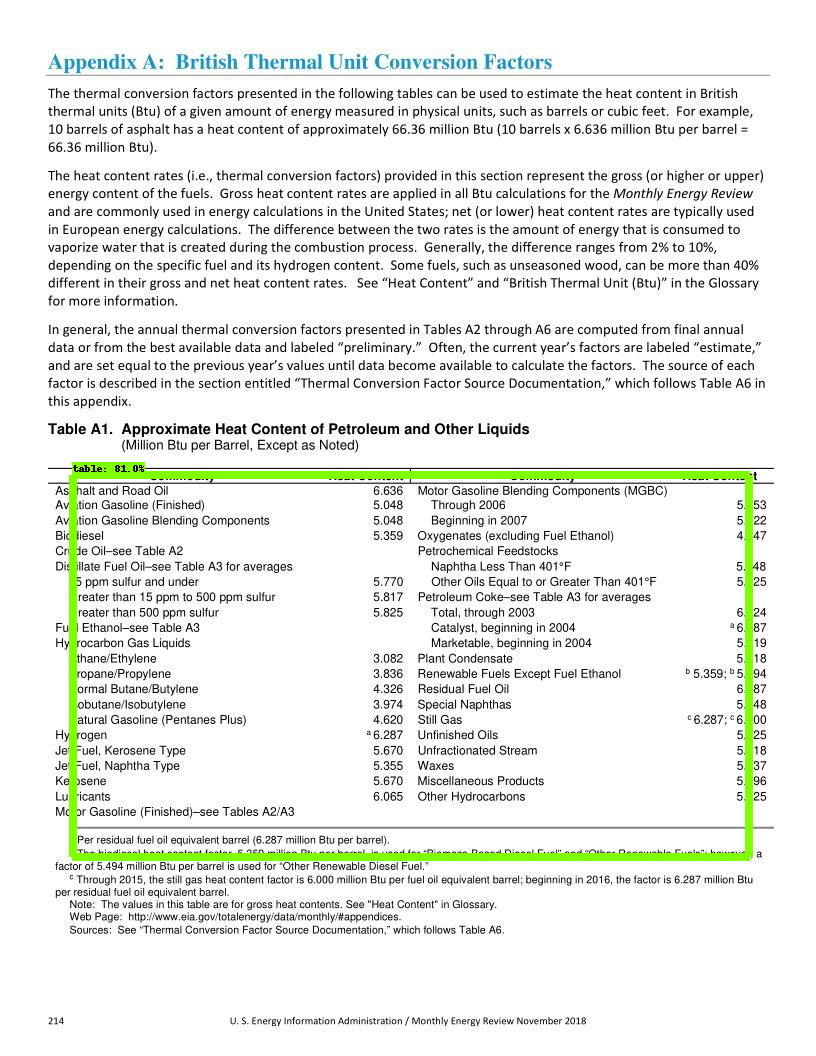

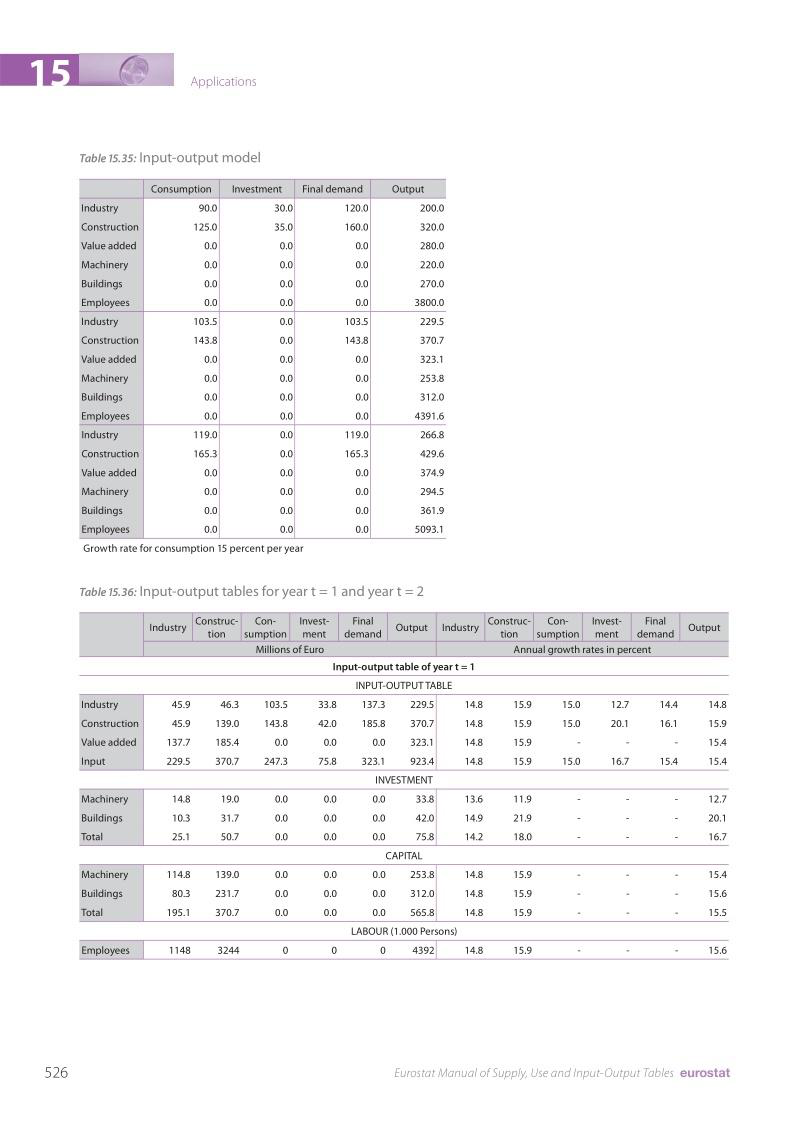

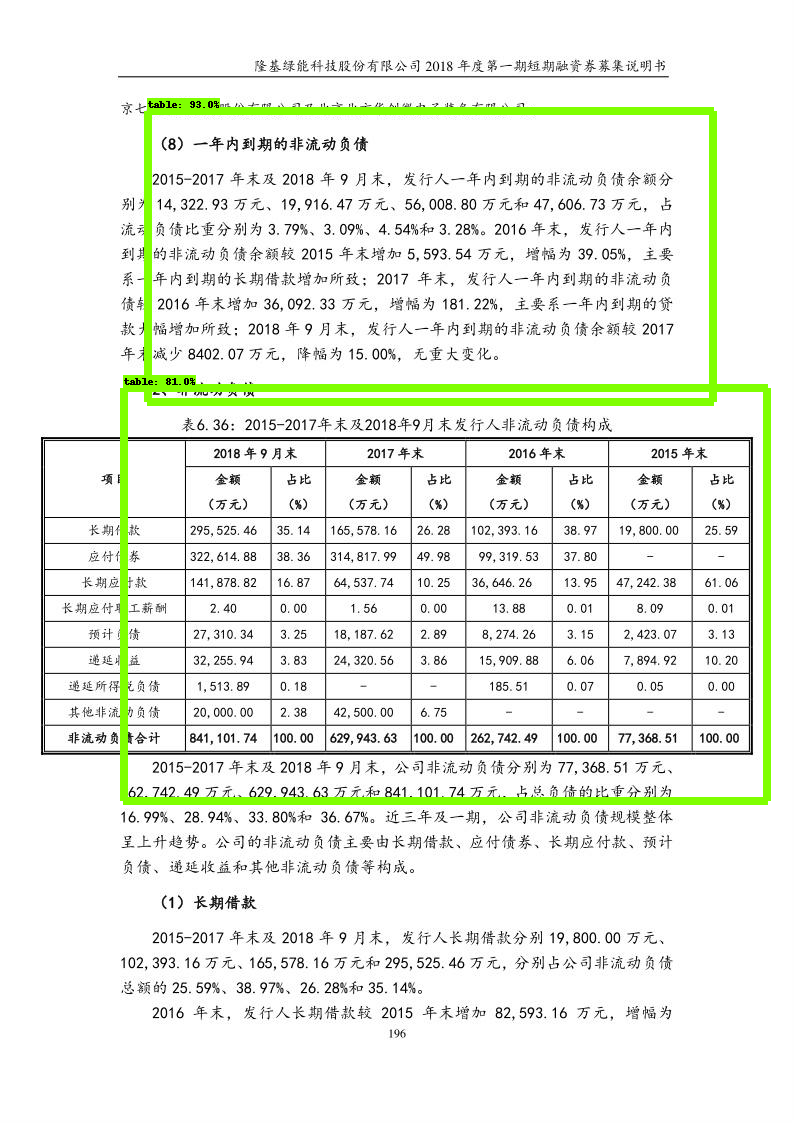

In [ ]:
for _, _, files in os.walk(PATH):
  for tfile in files:
    show_inference(model, os.path.join(PATH_TR, tfile), os.path.join(PATH, tfile))

# Скачивание модели

Полученный экспорт модели можно скачать

Сначала заархивируем модель

In [ ]:
!zip -r /content/model.zip /content/out

  adding: content/out/ (stored 0%)
  adding: content/out/pipeline.config (deflated 66%)
  adding: content/out/checkpoint/ (stored 0%)
  adding: content/out/checkpoint/ckpt-0.data-00000-of-00001 (deflated 7%)
  adding: content/out/checkpoint/checkpoint (deflated 41%)
  adding: content/out/checkpoint/ckpt-0.index (deflated 80%)
  adding: content/out/saved_model/ (stored 0%)
  adding: content/out/saved_model/saved_model.pb (deflated 93%)
  adding: content/out/saved_model/assets/ (stored 0%)
  adding: content/out/saved_model/variables/ (stored 0%)
  adding: content/out/saved_model/variables/variables.index (deflated 80%)
  adding: content/out/saved_model/variables/variables.data-00000-of-00001 (deflated 7%)


А после скачаем

In [ ]:
files.download("/content/model.zip")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

### Вариант с копированием на гугл диск

Подключаемся к своему гугл диску

In [ ]:
drive.mount('/content/drive')

Затем копируем в нужную директорию на гугл диске

In [ ]:
!cp /content/model.zip "/content/drive/My Drive/Colab Notebooks/<YOUR_DIR>"